In [351]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import ast 
import seaborn as sns

### Histogram for Germination Frame Frequency

In [352]:
def germination_frequency(plots_folder: str, GERMINATION: list, output: int = 1) -> None:
  '''
  output denotes whether to output produced dictionary and plot to jupyter notebooks, shown by default

  creates a dictionary with germination frames as a key, and frequency as a value
  these frequencies are printed in the function
  a histogram plot is also produced
  '''
  germination_frames_list = GERMINATION.apply(lambda x: x.index(1)) #list of germination frames as indices

  #print times frame germination occurs
  frame_counts = Counter(germination_frames_list)
  sorted_frame_counts = sorted(frame_counts.items())
  for frame_number, count in sorted_frame_counts:
      if output == 1:
        print(f"Frame: {frame_number}, Frequency: {count}")
      
  #histogram plot 
  plt.hist(germination_frames_list, bins=289, color='pink', edgecolor='black')
  plt.title("Germination Times")
  plt.xlabel("Frame Number")
  plt.ylabel("Frequency")
  plt.grid()
  plt.savefig(plots_folder + "germination_frequency.jpg")

  if output != 1:
    plt.close()
  return 

### Descriptive Statistics

In [353]:
def group_by_germination(df, feature_str: list[str]):
  ''' 
  Takes in original data frame and list of features to analyze and group together
  returns grouped data
  '''
  data_stats = df.copy()

  for feature in feature_str:
    data_stats[feature] = data_stats[feature].apply(ast.literal_eval)

  data_stats['Germination Frame'] = data_stats['GERMINATION'].apply(lambda x: x.index(1)) #get germination frame where first "1" occurs 
  grouped_data = data_stats.groupby("Germination Frame")

  return grouped_data, data_stats

### Box Plots

In [354]:
def get_max(df, feature: str) -> int:
    data_max = []
    data = df[feature].apply(ast.literal_eval) 
    for row in data:
        data_max.append(max(row))
    return max(data_max)


def box_plot_statistics(germ_time, data, column: str, feature: str, max_feature: int, show_plot = 1):
    aligned_data = [pd.Series(data) for data in data[column]]
    aligned_df = pd.DataFrame(aligned_data)
    melted_aligned_df = aligned_df.melt(var_name='Frame', value_name=feature) #long format
    
    # plotting
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Frame', y=feature, data=melted_aligned_df)
    plt.axvline(x=germ_time, color='red', linestyle='--', label=f'Germination Frame {germ_time}')
    plt.title(f'{feature} Statistics for Spores Germinated at Frame {germ_time}')
    plt.xlabel('Frame')
    plt.xticks([0, 50, 100, 150, 200, 150, 200, 250])
    plt.ylabel(feature)
    plt.ylim(0, max_feature)
    plt.legend()
    plt.savefig(f"{plots_folder}  {feature} _boxplot_ + {germ_time} .jpg")
    
    if show_plot != 1:
        plt.close()

### Spatial

In [355]:
def plot_xy_germinationframe(df, show_plot = 1):  
  plt.figure(figsize=(12, 8))
  #plot
  scatter = plt.scatter(df['X_POSITION'], df['Y_POSITION'], c = df['Germination Frame'], cmap = 'gist_ncar', edgecolor='black', s=100)
  plt.colorbar(scatter, label='Germination Frame')
  plt.xlabel('X')
  plt.ylabel('Y')

  plt.gca().invert_yaxis()
  plt.title('Spores by Germination Frame')
  plt.grid(True)
  plt.savefig(f"{plots_folder}germinationframe_location.jpg")

  if show_plot != 1:
    plt.close()
  ###VALIDATE THIS overlay on tiff

### Signal Summation

In [356]:


def total_signal(df, INTENSITY, GERMINATION):
  germination_totalintensity = []

  df['Germination Frame'] = GERMINATION.apply(lambda x: x.index(1)) #get germination frame where first "1" occurs 
  #Germination_frame_column_index = df.loc["Germination Frame"]
  print(df.columns)
  for i in range(len(df)):
    spore_intensities = INTENSITY[i]
    spore_germination_frame = df.loc[i, "Germination Frame"]
    intensities_before_germination = spore_intensities[0:spore_germination_frame]
    itensities_before_germination_np = np.array(intensities_before_germination)
    total_intensity = np.sum(intensities_before_germination)
    germination_totalintensity.append(np.array([spore_germination_frame, total_intensity]))

  germination_totalintensity_np = np.array(germination_totalintensity)

  plt.scatter(germination_totalintensity_np[:, 0], germination_totalintensity_np[:, 1])
  plt.xlabel("Germination Frame")
  plt.ylabel("Sum Intensity")
  

    
  



### Main 

In [357]:
def Main(csv_path, plots_folder):
  df = pd.read_csv(csv_path)
  print(f"data has columns {list(df.columns)}...")

  # turning model data into lists
  INTENSITY: list[list] = df["INTENSITY"].apply(ast.literal_eval) 
  AREA: list[list] = df["AREA"].apply(ast.literal_eval)
  GERMINATION: list[list] = df["GERMINATION"].apply(ast.literal_eval)

  # germination frequency 
  germination_frequency(plots_folder, GERMINATION, 0)

  # group data by germination frame
  groups, data_stats = group_by_germination(df, ["INTENSITY", "AREA", "GERMINATION"])

  # used for plot limits 
  max_intensity = get_max(df, "INTENSITY")
  max_area = get_max(df, "AREA")

  # iterate through groups
  for name, group in groups: # name is germination frames, and groups is data 
    box_plot_statistics(name, group, "INTENSITY", "Intensity", max_intensity, 0)
    box_plot_statistics(name, group, "AREA", "Area", max_intensity, 0)
    break 

  #plot x, y, and germination frame  
  plot_xy_germinationframe(data_stats, 0)  
  total_signal(df, INTENSITY, GERMINATION)


data has columns ['Unnamed: 0', 'INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION', 'X_POSITION', 'Y_POSITION']...
Index(['Unnamed: 0', 'INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION',
       'X_POSITION', 'Y_POSITION', 'Germination Frame'],
      dtype='object')


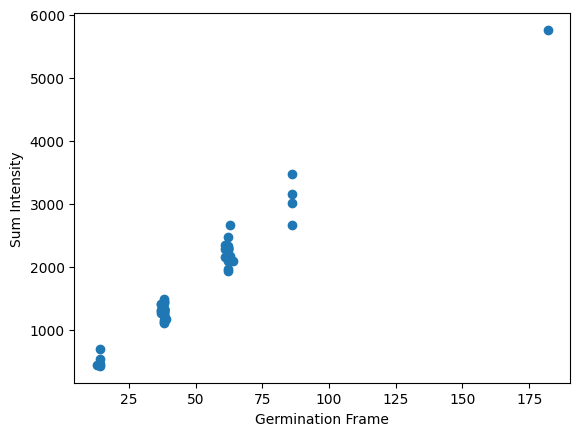

In [358]:
if __name__ == "__main__":
  csv_path = "/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/Model_Data.csv"
  plots_folder = "/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/Plots/"

  Main(csv_path, plots_folder)